In [2]:
from random import choices
from sage.all import *
from sage.rings.number_field.number_field import CyclotomicField
from sage.rings.integer_ring import ZZ
import numpy as np
import time
import matplotlib.pyplot as plt

In [ ]:
### Define helper functions

def recover_sparse_cyclotomic(p: int, l: int, Mscale=10 ** 6, Nscale=20, obj_dims=1, noise=0.0) -> tuple[list[int], Matrix]:
    """For a randomly generated cyclotomic integer `z` summed from `l` `p`^th roots of unity,
    generates LLL (short, nearly orthogonal) basis vectors to approximate `z`. \n

    Each basis vector `vec` consists of:
    - `vec`[0:2] corresponding to the Re and Im parts of the objective value
    - `vec`[2:p+2] corresponding to the coefficients for each root of unity
    - `vec`[p+2:p+2+obj_dims] corresponding to the coefficients for Re and Im parts of target value

    ### Parameters:
    - `p`: order of root of unity (must be prime).
    - `l`: number of nonzero integer terms in cyclotomic integer decomposition.
    - `Mscale`: lattice scaling factor for objective complex values.
    - `Nscale`: lattice scaling factor for integer mapping.
    - `obj_dims`: number of dimensions assigned to target value (1 or 2).
    - `noise`: standard deviation of Gaussian noise to include in input cyclotomic integer.

    ### Returns:
    - `exp`: exponents of roots of unity used to generate z.
    - `lll_mat`: List of candidate basis vectors as output of LLL algorithm.
    """
    if not is_prime(p):
        raise ValueError("p must be prime")
    
    if not (obj_dims == 1 or obj_dims == 2):
        raise ValueError("obj_dims must be 1 or 2")

    # Initialize cyclotomic field
    K = CyclotomicField(p)
    zeta = K.gen()

    # Generate random cyclotomic integer
    X = [0]*p
    exps = choices(range(p), k=l)
    for i in exps:
        X[i] += 1
    z = sum(X[i] * zeta**i for i in range(p))
    if noise:
        z += np.random.normal(scale=noise) + 1j * np.random.normal(scale=noise)

    # Construct the lattice basis matrix
    B = Matrix(ZZ, p + obj_dims, p + obj_dims + 2)

    # Set first row to real parts
    zeta_re = [CC(zeta**i).real() for i in range(p)]
    for i in range(p):
        B[i, 0] = int(round(zeta_re[i] * Mscale))
    B[p, 0] = -1 * int(round(CC(z).real() * Mscale))  # target real part

    # Set second row to imaginary parts
    zeta_im = [CC(zeta**i).imag() for i in range(p)]
    for i in range(p):
        B[i, 1] = int(round(zeta_im[i] * Mscale))
    B[p + obj_dims - 1, 1] = -1 * int(round(CC(z).imag() * Mscale))  # target imag part

    # Scaled identity matrix
    for i in range(p):
        B[i, 2 + i] = Nscale
    B[p, p+2] = 1
    if obj_dims == 2:
        B[p+1, p+3] = 1

    B_lll = B.LLL()
    return exps, B_lll


def filter_candidate(vec: list, p: int, l: int, Nscale: int, obj_dims: int) -> bool:
    """Check whether candidate vector satisfies constraints of 
    the cyclotomic integer decomposition integer relation problem.
    - `abs(vec)[0:-obj_dims]` sums to `l`.
    - `abs(vec)[-obj_dims:]` indicates one multiple of the target value is included in basis vector.

    ### Parameters:
    - `vec`: vector to evaluate, from `recover_sparse_cyclotomic`.
    - `p`: order of root of unity
    - `l`: number of expected nonzero integer terms.
    - `Nscale`: lattice scaling factor for integer mapping.
    - `obj_dims`: number of dimensions assigned to objective value (1 or 2).

    ### Returns:
    - boolean indicating whether `vec` satisfies the following:
    \t - `vec[0:-obj_dims]` has 1-norm `l * Nscale`.
    \t - `vec[-obj_dims:]` indicates one multiple of the target value is included in basis vector.
    """
    
    # Check for sum of integer entries
    if obj_dims == 1 and np.abs(vec[-1]) == 1:
        return (vec[-1] * np.sum(vec[:-1])) % (p * Nscale) == (l * Nscale * vec[-1]) % (p * Nscale)
    
    if obj_dims == 2:
        if (vec[-2] == 1 and vec[-1] == 1 and np.all(vec >= 0)) or (vec[-2] == -1 and vec[-1] == -1 and np.all(vec <= 0)):
            return np.sum(vec[:-2]) == l * Nscale * vec[-1]
    
    return False


def run_trials(primes, l, Mscale, Nscale, obj_dims, num_trials, noise):
    # Generate placeholder to record correct trials and time taken for each prime
    results = np.zeros(len(primes))
    
    for i in range(len(primes)):
        for j in range(num_trials):
            exps, lll_mat = recover_sparse_cyclotomic(primes[i], l, Mscale=Mscale, Nscale=Nscale, obj_dims=obj_dims, noise=noise)
            bool_arr = np.array([filter_candidate(row[2:], primes[i], l, Nscale=N, obj_dims=obj_dims) for row in np.array(lll_mat)])
            candidates = np.array(lll_mat)[bool_arr]

            # Match successful candidate vectors
            if candidates.any():
                expected_arr = np.zeros(primes[i])
                for exp in exps:
                    expected_arr[exp] += N
                diff_vec = candidates[0][-1] * candidates[0][2:-obj_dims] - expected_arr
                # Check if candidate and actual vector differ by all 1's vector
                if (diff_vec == diff_vec[0]).all():
                    results[i] += 1
    return results


def run_trials_timed(primes, l, Mscale, Nscale, obj_dims, num_trials, noise):
    # Generate placeholder to record correct trials and time taken for each prime
    results = np.zeros(len(primes))
    times = np.zeros(len(primes))
    init_time = time.time()
    
    for i in range(len(primes)):
        start_time = time.time()
        print(f"Beginning prime {primes[i]} at {start_time - init_time}")
        for j in range(num_trials):
            exps, lll_mat = recover_sparse_cyclotomic(primes[i], l, Mscale=Mscale, Nscale=Nscale, obj_dims=obj_dims, noise=noise)
            bool_arr = np.array([filter_candidate(row[2:], primes[i], l, Nscale=N, obj_dims=obj_dims) for row in np.array(lll_mat)])
            candidates = np.array(lll_mat)[bool_arr]

            # Match successful candidate vectors
            if candidates.any():
                expected_arr = np.zeros(primes[i])
                for exp in exps:
                    expected_arr[exp] += N
                # if not (np.abs(candidates[0][2:-obj_dims]) - expected_arr).any():
                #     results[i] += 1
                diff_vec = candidates[0][-1] * candidates[0][2:-obj_dims] - expected_arr
                # Check if candidate and actual vector differ by all 1's vector
                if (diff_vec == diff_vec[0]).all():
                    results[i] += 1
        end_time = time.time()
        times[i] = end_time - start_time
    return results, times


In [ ]:
### Check LLL output matrix and candidates in a single trial
exps, lll_mat = recover_sparse_cyclotomic(11, 11, Mscale=10**15, Nscale=20, obj_dims=1, noise=(5 * (10 ** -3)))
bool_arr = np.array([filter_candidate(row[2:], 11, 11, Nscale=20, obj_dims=1) for row in np.array(lll_mat)])
candidates = np.array(lll_mat)[bool_arr]

print(exps)
print(lll_mat)

(-0.007743775546217161-0.0016096068429686668j)
[4, 2, 1, 5, 6, 10, 7, 4, 5, 4, 0]
[    1    -1    20    20    20    20    20    20    20    20    20    20    20     0]
[ 1743   643  -820  -980  -320  2780  -360  1960  1740 -2540  -820    60  -660    88]
[  733  -791  3500 -1960  -780 -1760  1300  1160 -1140  -300  -980  1220  -420   -29]
[ 1862 -2041   380   740  -220 -2920   720 -1640  4160 -1900 -1860   420  1860   -35]
[-3990 -1022  1880  1620 -2380  -440  -880  3020   740 -3120  2660 -2520  -400     9]
[-2113  3584  2440 -1560  2200 -2540  -220  1640  4320 -2480  -900 -2600  -120    54]
[ -386  2776 -1200  2160 -4640   680   320 -2040  1680 -1120 -2160  2580  3980   -87]
[-3699  1832 -1240   580 -2260  2760  2720  -860   380 -3780  1740  3060 -2860    48]
[ 3635 -4763  2400 -1700 -1400  2160   880 -1940   960  2300  -820 -4180   840    41]
[ 6081  1611   460   920  -100 -1140 -1720 -3220   740 -1620  1940  4600 -1140  -137]
[-1310 -1237 -1840  4480  1340 -3380  1800   900  1780  24

In [8]:
### Run trials
# primes = [11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
primes = [13, 17, 19, 23]
# primes = [37, 41, 43, 47]
l = 3
# M = 10 ** 15 # maximum and most effective
# N = 20 # decrease for errorless trials
dims = 1
trials = 1000

for M in [10 ** 3, 10 ** 4, 10 ** 5, 10 ** 6, 10 ** 7]:
    for N in [2, 500]:
        results = run_trials(primes, l, M, N, dims, trials, noise=(10 ** -4))
        print(f"M = {M}, N = {N}: {results}")

# print(f"Results: {results}")
# print(f"Times: {times}")

M = 1000, N = 2: [985. 964. 930. 737.]
M = 1000, N = 500: [50. 41. 29. 15.]
M = 10000, N = 2: [999. 992. 960. 829.]
M = 10000, N = 500: [591. 537. 349. 305.]
M = 100000, N = 2: [549. 277. 193. 140.]
M = 100000, N = 500: [980. 894. 897. 772.]
M = 1000000, N = 2: [16.  7.  4.  1.]
M = 1000000, N = 500: [1000.  994.  948.  830.]
M = 10000000, N = 2: [1. 0. 0. 0.]
M = 10000000, N = 500: [937. 746. 555. 470.]


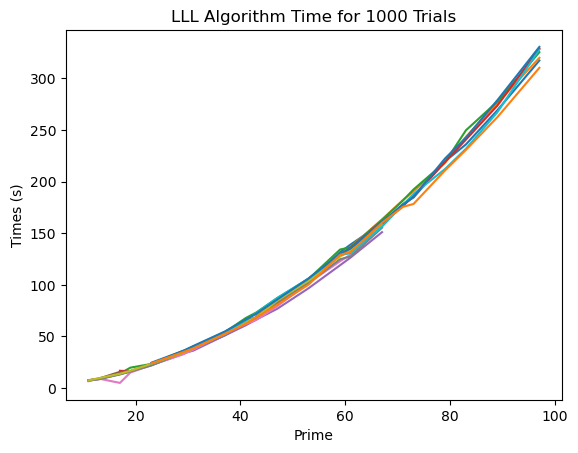

In [ ]:
### Plot algorithm times

primes1 = [11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
y1 = [7.39, 9.03, 13.57, 16.12, 22.28, 33.12, 37.69, 51.03, 62.22, 68.12, 82.75, 102.83, 131.57, 139.03, 159.72, 178.36, 184.52, 219.53, 235.96, 269.08, 317.2]
primes2 = [43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
y2 = [70.57, 83.54, 105.48, 128.69, 136.67, 163.46, 182.18, 190.58, 218.12, 243.28, 276.19, 319.81]
primes3 = [17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
y3 = [14.08, 19.81, 23.41, 35.98, 38.23, 54.1, 67.84, 73.2, 87.13, 105.78, 134.18, 136.31, 162.83, 181.77, 192.35, 218.69, 249.65, 277.42, 325.29]
y4 = [16.76, 16.34, 23.5, 35.46, 40.27, 53.13, 65.43, 68.38, 84.14, 105.89, 129.19, 133.91, 159.11, 176.45, 185.99, 218.89, 240.68, 273.58, 328.75]
primes5 = [11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67]
y5 = [7.68, 8.55, 13.71, 16.28, 22.88, 33.63, 36.28, 51.04, 60.79, 66.36, 76.79, 96.77, 119.01, 126.43, 151.02]
y6 = [7.6, 9.27, 15.74, 16.44, 22.61, 34.04, 38.88, 52.53, 64.36, 68.41, 81.93, 104.66, 128.65, 136.04, 161.69]
y7 = [6.69, 9.2	, 5.02, 15.09, 22.28, 32.57, 37.28, 53.33, 62.09, 65.99, 79.3, 101.91, 122.87, 129.3, 158.48]
y8 = [7.26, 8.65, 13.2, 16.09, 21.85, 34.56, 38.6, 52.81, 64.07, 68.83, 83.43, 101.96, 124.82, 127.44, 155.34]
y9 = [7.5, 9.62, 13.91, 16.83, 23.56, 34.13, 38.78, 52.3, 64.21, 68.49, 84.68, 104.02, 127.4, 133.18, 157.4]
primes10 = [23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
y10 = [23.92, 35.08, 40.37, 54.3, 65.49, 72.66, 87.27, 106.11, 128.99, 130.59, 156.43, 177.59, 187.93, 212.07, 231.79, 267.18, 327.89]
y11 = [24.59, 35.97, 40.75, 54.77, 66.35, 71.99, 85.75, 106.26, 130.17, 135.28, 161.2, 177.51, 185.21, 222.26, 242.55, 278.79, 330.36]
y12 = [24.01, 34.7, 38.5, 52.59, 62.29, 68.35, 80.7, 100.25, 129.07, 131.77, 160.13, 175.53, 178.31, 210.72, 230.7, 262.39, 310.14]
plt.plot(primes1, y1)
plt.plot(primes2, y2)
plt.plot(primes3, y3)
plt.plot(primes3, y4)
plt.plot(primes5, y5)
plt.plot(primes5, y6)
plt.plot(primes5, y7)
plt.plot(primes5, y8)
plt.plot(primes5, y9)
plt.plot(primes10, y10)
plt.plot(primes10, y11)
plt.plot(primes10, y12)
plt.title("LLL Algorithm Time for 1000 Trials")
plt.xlabel("Prime")
plt.ylabel("Times (s)")
plt.show()

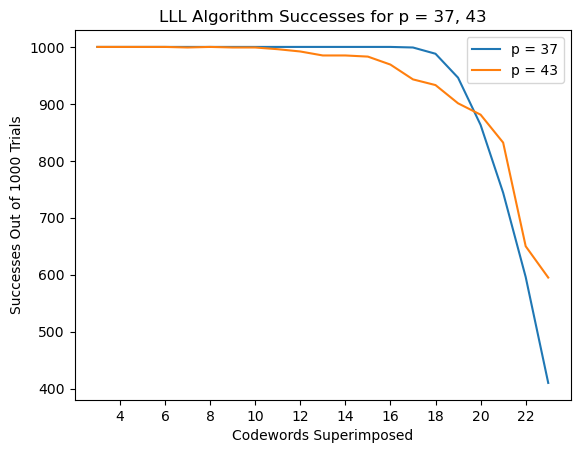

In [ ]:
### Plot successes for p = 37, 43

codewords = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
successes37 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 988, 946, 863, 744, 596, 410]
successes43 = [1000, 1000, 1000, 1000, 999, 1000, 999, 999, 996, 992, 985, 985, 983, 969, 943, 933, 901, 881, 832, 650, 595]
plt.plot(codewords, successes37, label='p = 37')
plt.plot(codewords, successes43, label='p = 43')
plt.title("LLL Algorithm Successes for p = 37, 43")
plt.xlabel("Codewords Superimposed")
plt.xticks([4, 6, 8, 10, 12, 14, 16, 18, 20, 22])
plt.ylabel("Successes Out of 1000 Trials")
plt.legend()
plt.show()

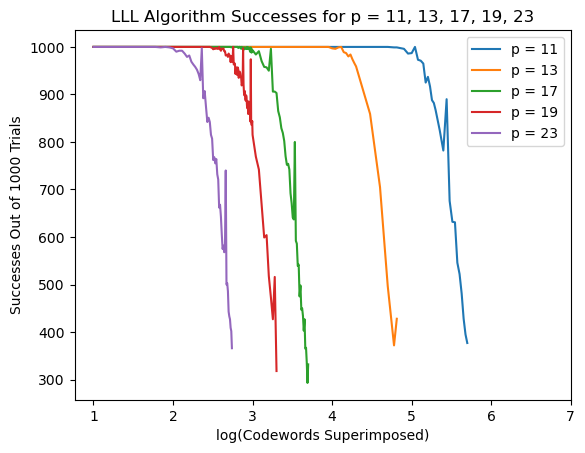

In [ ]:
### Plot algorithm successes for p = 11, 13, 17, 19, 23

codewords11 = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 30000, 40000, 50000, 60000, 65000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000, 225000, 250000, 275000, 300000, 325000, 350000, 375000, 400000, 425000, 450000, 475000, 500000]
codewords13 = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 30000, 40000, 50000, 60000, 65000]
codewords17 = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000]
codewords19 = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
codewords23 = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550]
log_cwords11 = np.log10(codewords11)
log_cwords13 = np.log10(codewords13)
log_cwords17 = np.log10(codewords17)
log_cwords19 = np.log10(codewords19)
log_cwords23 = np.log10(codewords23)
successes11 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 999, 998, 996, 986, 987, 1000, 973, 971, 965, 925, 937, 917, 888, 882, 867, 825, 782, 890, 676, 632, 631, 546, 522, 481, 428, 395, 377]
successes13 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 997, 996, 999, 1000, 989, 987, 980, 984, 974, 966, 959, 859, 705, 497, 372, 428]
successes17 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 998, 998, 1000, 1000, 999, 999, 996, 1000, 999, 999, 999, 999, 997, 995, 999, 999, 998, 996, 997, 1000, 996, 999, 998, 996, 999, 997, 993, 990, 997, 999, 996, 988, 995, 990, 993, 984, 991, 970, 958, 957, 950, 996, 906, 906, 903, 865, 852, 829, 819, 802, 770, 752, 754, 742, 692, 671, 641, 637, 800, 592, 586, 539, 542, 475, 498, 447, 450, 434, 403, 427, 365, 367, 336, 293, 332]
successes19 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 998, 995, 997, 996, 998, 996, 996, 1000, 995, 992, 996, 996, 997, 991, 991, 982, 983, 983, 979, 986, 981, 982, 968, 981, 972, 968, 1000, 963, 963, 965, 943, 957, 951, 941, 957, 953, 935, 945, 948, 945, 937, 934, 919, 923, 925, 997, 921, 904, 898, 907, 891, 887, 898, 894, 877, 871, 885, 859, 885, 880, 864, 861, 856, 843, 974, 842, 836, 837, 844, 815, 769, 742, 668, 599, 604, 518, 473, 427, 516, 318]
successes23 = [1000, 1000, 1000, 1000, 1000, 1000, 999, 1000, 999, 997, 990, 992, 992, 986, 979, 982, 969, 963, 958, 952, 943, 930, 997, 892, 907, 873, 842, 851, 842, 815, 807, 762, 768, 755, 764, 732, 721, 662, 668, 643, 606, 575, 582, 568, 578, 740, 500, 503, 486, 443, 433, 427, 409, 402, 366]
plt.plot(log_cwords11, successes11, label='p = 11')
plt.plot(log_cwords13, successes13, label='p = 13')
plt.plot(log_cwords17, successes17, label='p = 17')
plt.plot(log_cwords19, successes19, label='p = 19')
plt.plot(log_cwords23, successes23, label='p = 23')
plt.title("LLL Algorithm Successes for p = 11, 13, 17, 19, 23")
plt.xlabel("log(Codewords Superimposed)")
plt.xticks([1, 2, 3, 4, 5, 6, 7])
plt.ylabel("Successes Out of 1000 Trials")
plt.legend()
plt.show()